<a href="https://www.kaggle.com/code/swapanroy/exploring-zillow-sales-pricing-dataset?scriptVersionId=235734829" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


Comprehensive guide for ingesting & exploring the Zillow -Sales Pricing dataset

In [1]:
import os
import re
import pandas as pd
import json
from pathlib import Path
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import numpy as np
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

## Load Data

In [2]:
# File to load 

# Read in CSV or Parquet Files
city_prices = pd.read_csv('/kaggle/input/zillow-house-price-data/Sale_Prices_City.csv')

# Convert to DataFrame
df = pd.DataFrame(city_prices)


# Display some records
df.head(5)


,Unnamed: 0,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,...,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03
0,0,6181,New York,New York,1,NaN,NaN,NaN,NaN,NaN,...,563200.0,570500.0,572800.0,569900.0,560800.0,571500.0,575100.0,571700.0,568300.0,573600.0
1,1,12447,Los Angeles,California,2,507600.0,489600.0,463000.0,453100.0,438100.0,...,706800.0,711800.0,717300.0,714100.0,711900.0,718400.0,727100.0,738200.0,760200.0,NaN
2,2,39051,Houston,Texas,3,138400.0,135500.0,132200.0,131000.0,133400.0,...,209700.0,207400.0,207600.0,207000.0,211400.0,211500.0,217700.0,219200.0,223800.0,NaN
3,3,17426,Chicago,Illinois,4,325100.0,314800.0,286900.0,274600.0,268500.0,...,271500.0,266500.0,264900.0,265000.0,264100.0,264300.0,270000.0,281400.0,302900.0,309200.0
4,4,6915,San Antonio,Texas,5,130900.0,131300.0,131200.0,131500.0,131600.0,...,197100.0,198700.0,200200.0,200800.0,203400.0,203800.0,205400.0,205400.0,208300.0,NaN


In [3]:
# Display shape 

print("Shape:",df.shape)


# Display info
print("------------- Column Name ------------- ")

print(df.columns)

Shape: (3728, 150)
------------- Column Name ------------- 
Index(['Unnamed: 0', 'RegionID', 'RegionName', 'StateName', 'SizeRank',
       '2008-03', '2008-04', '2008-05', '2008-06', '2008-07',
       ...
       '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11',
       '2019-12', '2020-01', '2020-02', '2020-03'],
      dtype='object', length=150)


This gives us a basic understanding of the data structure. We have:

3,728 rows (Cities)
150 columns including identifiers and monthly data from 2008-2020

## EDA with Time Series Analysis and Visualization

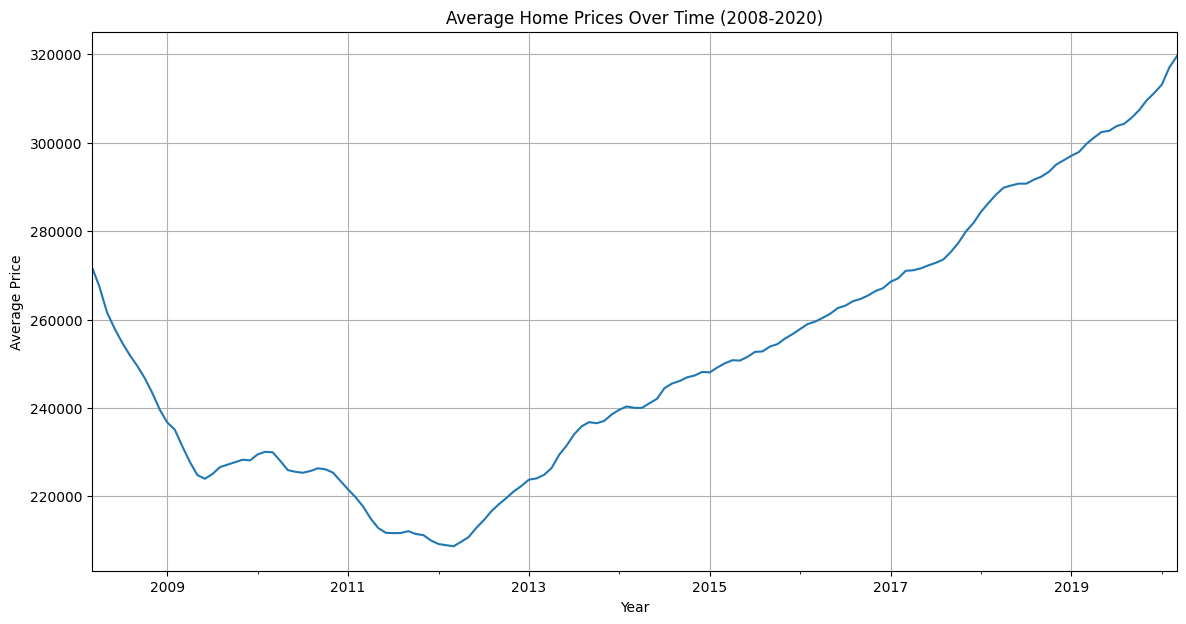

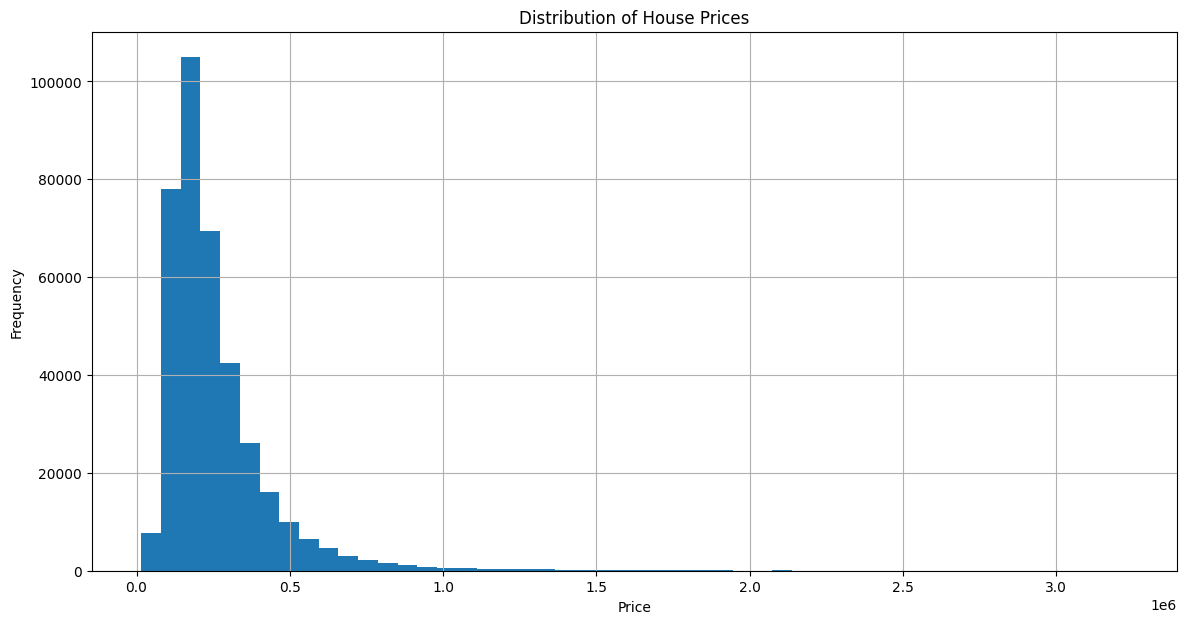

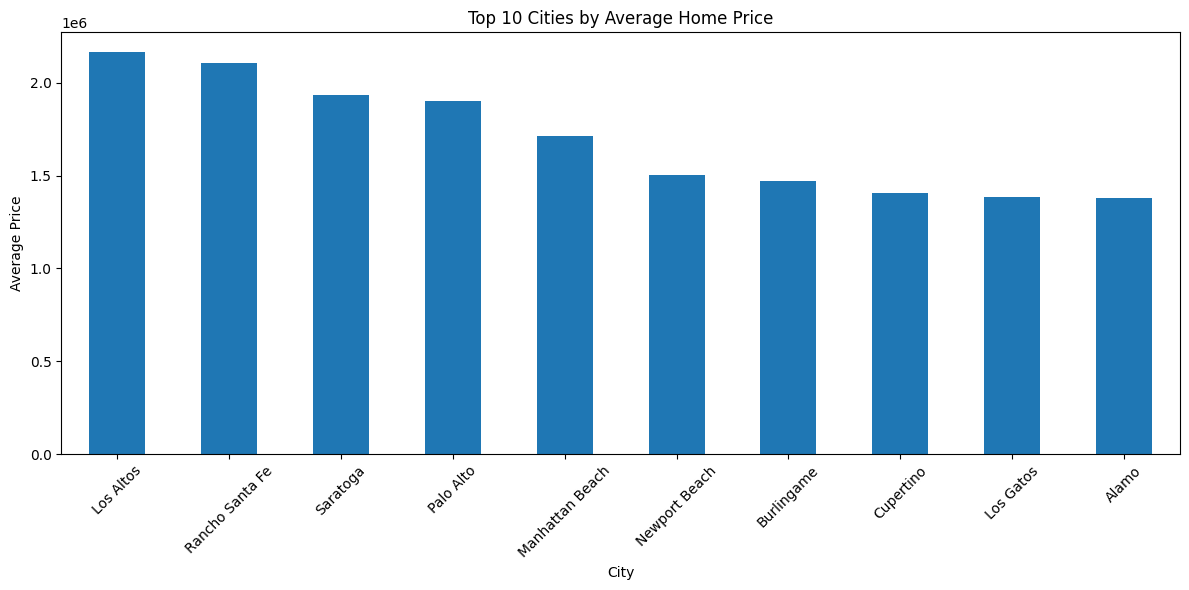

<Figure size 1400x800 with 0 Axes>

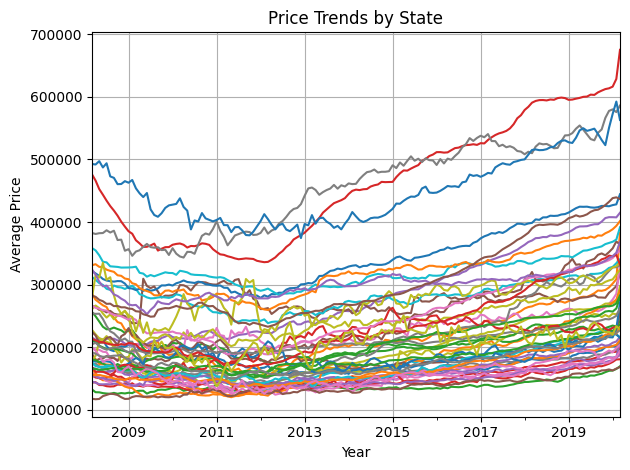

In [4]:
# Convert the dataframe to make it suitable for time series analysis, create a sub dataframe for the time series data
time_cols = [col for col in df.columns if col.startswith('20')]  # Get all year-month columns
id_cols = [col for col in df.columns if not col.startswith('20')]  # Get identifier columns

# Convert dataframe from wide to long format
df_melted = pd.melt(df, id_vars=id_cols, value_vars=time_cols, 
                    var_name='Month', value_name='Price')

# Convert Month to datetime
df_melted['Month'] = pd.to_datetime(df_melted['Month'], format='%Y-%m')

# Plot overall price trends
plt.figure(figsize=(14, 7))
df_melted.groupby('Month')['Price'].mean().plot()
plt.title('Average Home Prices Over Time (2008-2020)')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

# Show price distribution
plt.figure(figsize=(14, 7))
plt.hist(df_melted['Price'].dropna(), bins=50)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Analyze by region/state if those columns exist
if 'RegionName' in df.columns and 'StateName' in df.columns:
    # Top 10 cities by average price
    top_cities = df_melted.groupby('RegionName')['Price'].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(12, 6))
    top_cities.plot(kind='bar')
    plt.title('Top 10 Cities by Average Home Price')
    plt.xlabel('City')
    plt.ylabel('Average Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Price trends by state
    state_prices = df_melted.groupby(['Month', 'StateName'])['Price'].mean().unstack()
    plt.figure(figsize=(14, 8))
    state_prices.plot(legend=False)
    plt.title('Price Trends by State')
    plt.xlabel('Year')
    plt.ylabel('Average Price')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Insights on the EDA plots 

## Image 1: Average Home Prices Over Time (2008-2020)

This plot shows the national trend in average home prices over the 12-year period:

1. **Housing Crisis Impact (2008-2012)**: The sharp decline at the beginning reflects the impact of the 2008 financial crisis and housing market crash. Prices fell from around  270K in 2008 to a bottom of about $ 210K in 2012 - approximately a 22% decline.

2. **Recovery Phase (2012-2017)**: Starting in 2012, there's a steady recovery with consistent price growth. This represents the housing market rebuilding after the crisis, with prices regaining their pre-crash levels around 2016.

3. **Acceleration Phase (2017-2020)**: From 2017 onward, we see a steeper growth curve indicating an increasingly hot housing market. By the end of 2019 and into 2020, the growth rate accelerates further, reaching approximately $320,000 by 2020 - representing a significant increase from the 2012 low.

## Image 2: Distribution of House Prices

This histogram shows how house prices are distributed across all cities vs time periods:

1. **Right-skewed Distribution**: Most property prices are concentrated in the lower ranges (under $500,000), with a long tail extending toward higher prices.

2. **Price Concentration**: The highest frequency is ~ $ ( 200K - 300K), indicating this is the most common price range in the dataset.

3. **Luxury Market**: There's a small number of properties in the 1M+ range, and very few properties priced above $ 2M, showing how the luxury market represents a small portion of the overall housing landscape.

## Image 3: Top Cities & State Trends

These two charts provide geographic insights:

1. **Top 10 Cities by Price**: 
   - California dominates the highest-priced markets with Los Altos at the top (approximately $2.1M average).
     
   - The top 10 cities all have average prices above $1.3M, significantly higher than the national average

2. **Price Trends by State**:
   - The multi-colored lines show different states' price trajectories
   - The top-performing states (like California, represented by the red line) show the steepest increases, especially in 2019-2020
   - Most states follow the same general pattern of decline (2008-2012), recovery (2012-2017), and acceleration (2017-2020)
   - There's significant variation in both baseline prices and growth rates between states
   - By 2020, the highest-priced state reaches around $ (650,000-700,000) average prices

## Key Insights from the Time Series Analysis:

1. **Market Cycles**: The data clearly captures a full housing market cycle - from crash to recovery to boom.

2. **Geographic Premium**: Location remains the dominant factor in housing prices, with certain areas commanding massive premiums.

3. **Uneven Recovery**: While all areas generally followed the same trend pattern, some markets recovered much more dramatically than others.

4. **Acceleration**: The 2019-2020 period shows particularly strong growth, potentially indicating a housing boom ahead of the pandemic (which would begin affecting markets in early-mid 2020).

5. **Price Disparity**: The enormous gap between the national average (~ 320K by 2020) and top markets like Los Altos (~$ 2.1M) highlights the extreme regional variation in the US housing market.



## Seasonal Decomposition and Correlation Analysis

### We will use "statsmodels.tsa.seasonal import seasonal_decompose"

1. **statsmodels**: This is a Python library that provides classes and functions for estimating many different statistical models, as well as for conducting statistical tests, and statistical data exploration.

2. **statsmodels.tsa**: This is a submodule within statsmodels that specifically deals with time series analysis.  tsa stands for "time series analysis."

3. **statsmodels.tsa.seasonal**: This is a further submodule within statsmodels.tsa that provides tools for working with the seasonality of time series data.

4. **seasonal_decompose**: This is a specific function within the statsmodels.tsa.seasonal module.  The seasonal_decompose function is used to decompose a time series into its constituent parts:

**Trend**: The long-term direction of the data.

**Seasonal**: The repeating patterns within a fixed time period.

**Residual (or Error)**: The random, irregular fluctuations.

Example: https://www.statsmodels.org/v0.13.5/examples/notebooks/generated/stl_decomposition.html

## Machine Learning Logic in Time Series Decomposition

The seasonal decomposition process involves several underlying machine learning and statistical concepts. Let me explain the ML logic that's being used in your code:

### Core ML Logic in Seasonal Decomposition

#### 1. Moving Average Smoothing
- **Algorithm**: The trend component is extracted using centered moving averages
- **Mathematical basis**: For a time series 𝑌ₜ, the moving average is calculated as:
  ```
  MA(Y)ₜ = (Yₜ₋(p/2) + ... + Yₜ + ... + Yₜ₊(p/2)) / p
  ```
  where p is the period
- **ML concept**: This is a form of low-pass filtering, removing high-frequency variations

#### 2. Pattern Recognition
- **Algorithm**: Seasonal patterns are identified by averaging values at the same point across multiple cycles
- **Mathematical approach**: For monthly data with annual seasonality:
  ```
  Seasonal[month] = Average(all values for that month) - Overall average
  ```
- **ML concept**: This is similar to feature extraction, isolating repeating patterns

#### 3. Residual Analysis
- **Algorithm**: Residuals are calculated as the difference between observed and (trend + seasonal)
- **ML concept**: This resembles error analysis in supervised learning models

#### 4. Correlation Analysis
- **ML concept**: Feature relationship analysis
- **Purpose**: Identifies which time periods have similar price behaviors
- **Mathematical basis**: Pearson correlation coefficient measures linear relationships
- **Application**: Helps detect structural changes in the time series

#### 5. Visualization as Feature Understanding

- **ML concept**: Feature importance visualization
- **Purpose**: Visual interpretation of complex relationships
- **Connection to ML**: Similar to correlation-based feature selection techniques

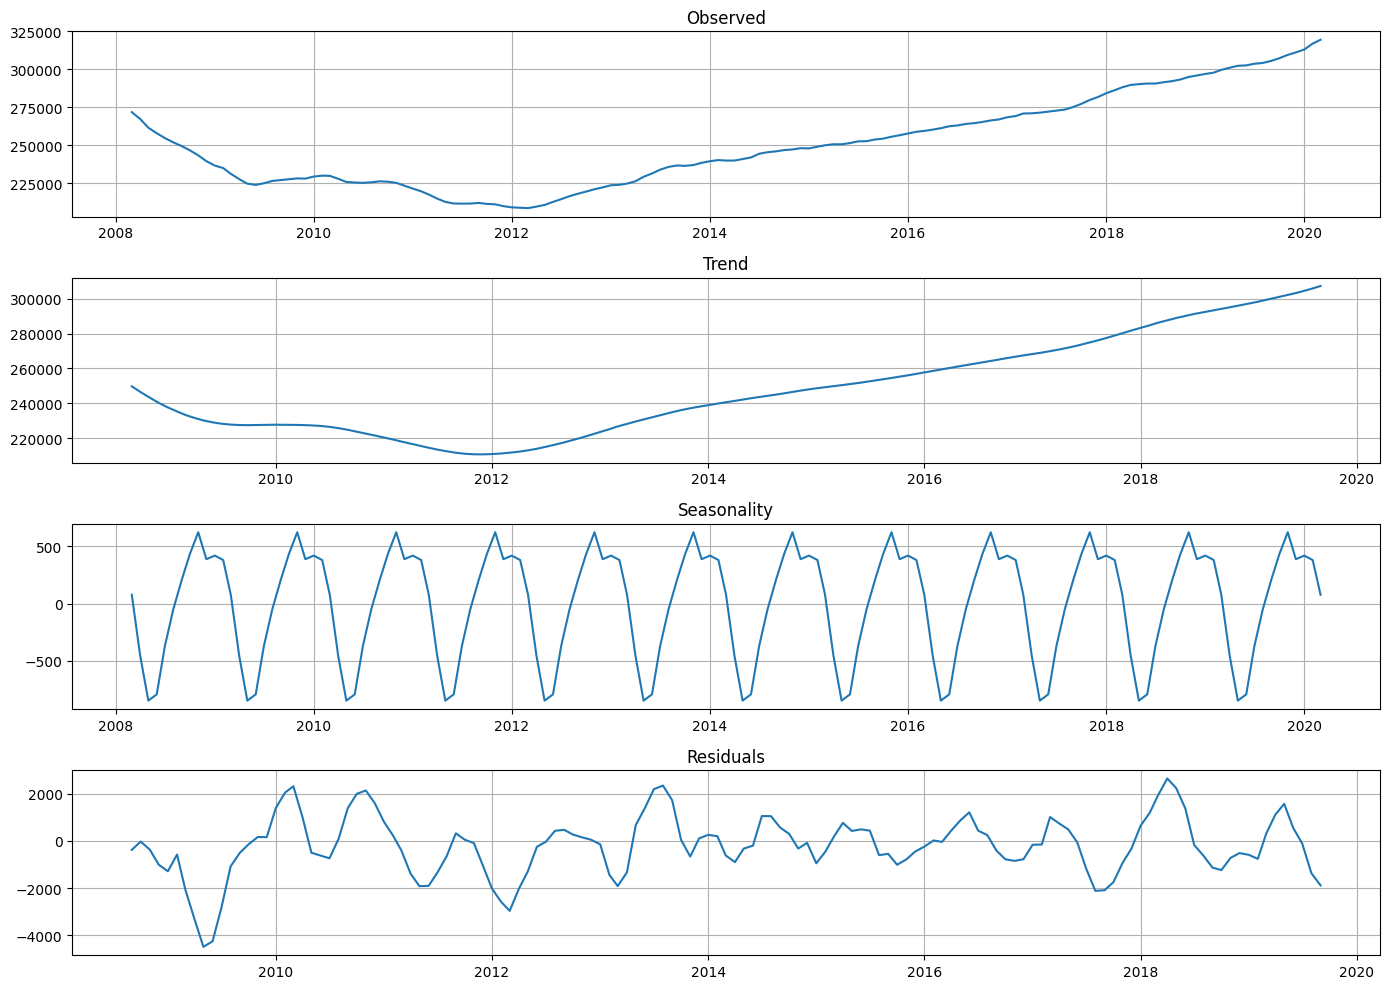

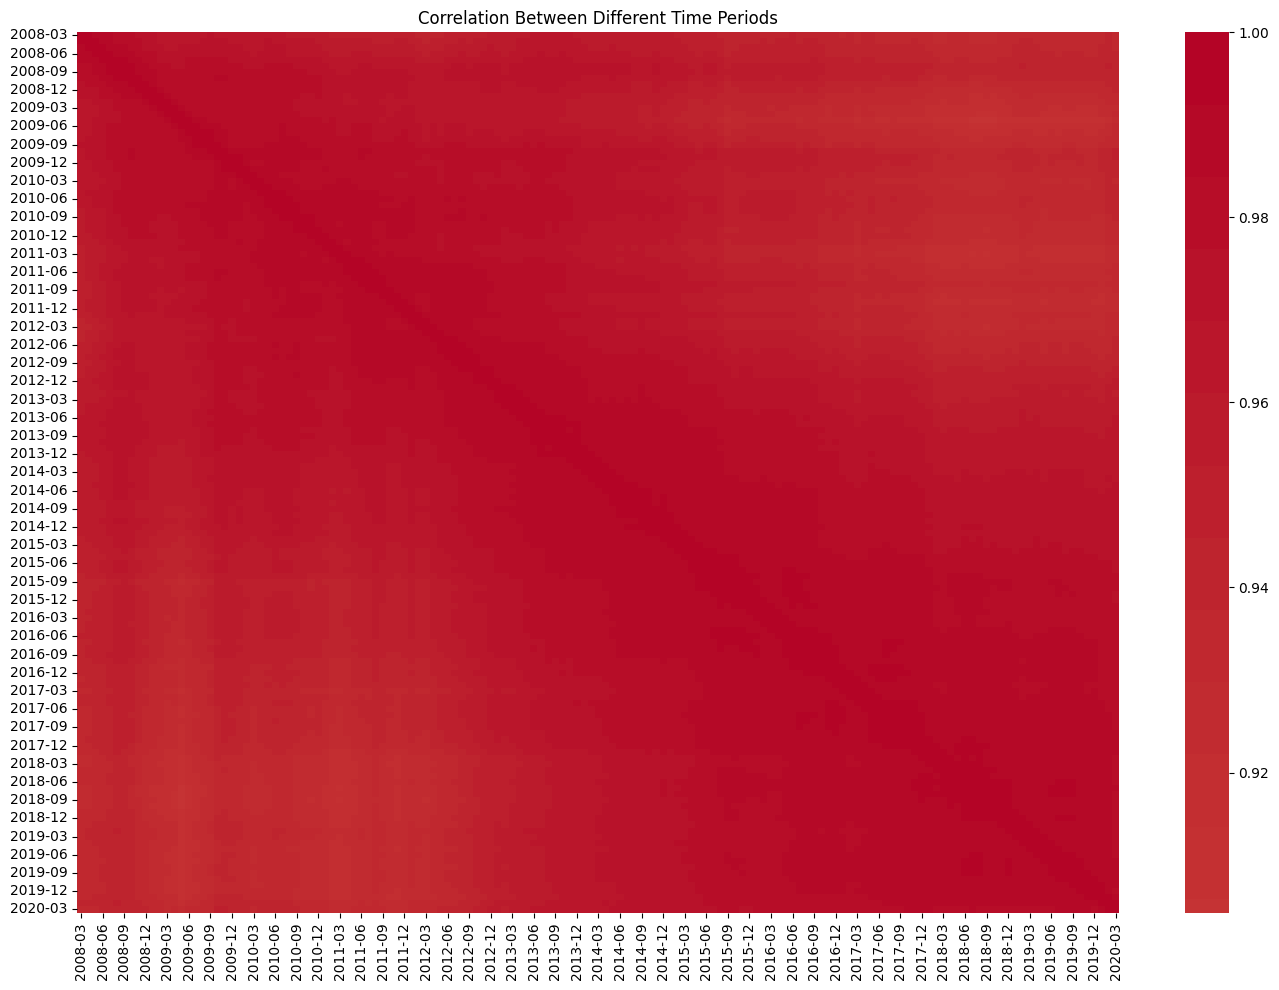

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

# Get the average price for each month across all regions
monthly_avg = df_melted.groupby('Month')['Price'].mean()

# Perform seasonal decomposition
try:
    decomposition = seasonal_decompose(monthly_avg, model='additive', period=12)
    
    # Plot the decomposed components
    plt.figure(figsize=(14, 10))
    
    plt.subplot(411)
    plt.plot(decomposition.observed)
    plt.title('Observed')
    plt.grid(True)
    
    plt.subplot(412)
    plt.plot(decomposition.trend)
    plt.title('Trend')
    plt.grid(True)
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal)
    plt.title('Seasonality')
    plt.grid(True)
    
    plt.subplot(414)
    plt.plot(decomposition.resid)
    plt.title('Residuals')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
except:
    print("Not enough data for seasonal decomposition. Skipping this analysis.")

# Calculate correlation between successive time periods
df_numeric = df.select_dtypes(include=[np.number])
time_cols = [col for col in df_numeric.columns if col.startswith('20')]
correlation_matrix = df_numeric[time_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Between Different Time Periods')
plt.tight_layout()
plt.show()

### Stationarity Testing using Augmented Dickey-Fuller test

ADF Statistic: 1.810498736914922
p-value: 0.9983696139042204
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


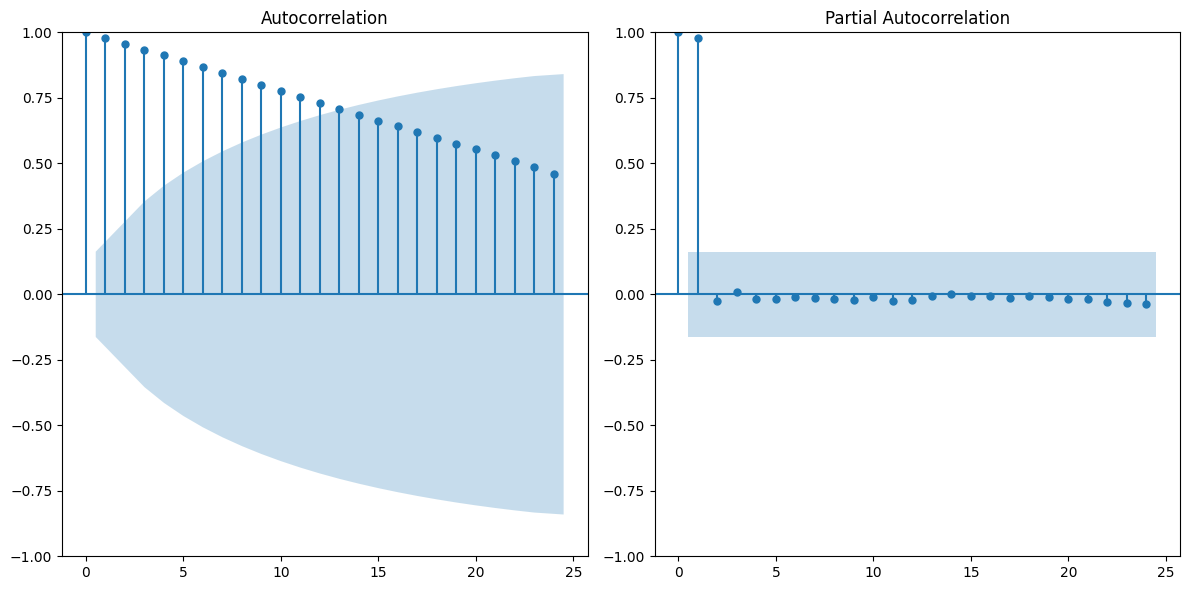

In [6]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(monthly_avg)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

# 2. Autocorrelation Analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(monthly_avg, lags=24, ax=plt.subplot(121))
plot_pacf(monthly_avg, lags=24, ax=plt.subplot(122))
plt.tight_layout()
plt.show()

### Time series is definitely non-stationary for several reasons:


* The ADF statistic (1.81) is positive and much larger than all the critical values, which are negative.
* For a series to be considered stationary, the ADF statistic should be more negative than the critical values.
* The extremely high p-value (0.998) confirms we cannot reject the null hypothesis of non-stationarity.

We need to do: 
seasonal decomposition 

## Part 1: Data Preparation and Feature Engineering

In [7]:

# Get the average price for each month across all regions
monthly_avg = df_melted.groupby('Month')['Price'].mean()

print("Monthly Average Index Type:")
print(type(monthly_avg.index))

# Fix the DatetimeIndex issue by ensuring proper date frequency
monthly_avg_with_freq = pd.Series(
    monthly_avg.values,
    index=pd.date_range(start=monthly_avg.index.min(), 
                        periods=len(monthly_avg), 
                        freq='MS')  # MS = Month Start
)

# Use the frequency-corrected series for decomposition
decomposition = seasonal_decompose(monthly_avg_with_freq, model='additive', period=12)

# Extract components
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Check the Month column type
if pd.api.types.is_datetime64_any_dtype(df_melted['Month']):
    print("Converting Month from datetime to numeric month number...")
    # Extract month number (1-12) from datetime
    df_melted['Month_Num'] = df_melted['Month'].dt.month
else:
    print("Month column is not datetime, using as is...")
    df_melted['Month_Num'] = df_melted['Month']

# Create cyclical features using the numeric month
df_melted['Month_Sin'] = np.sin(2 * np.pi * df_melted['Month_Num'] / 12)
df_melted['Month_Cos'] = np.cos(2 * np.pi * df_melted['Month_Num'] / 12)

Monthly Average Index Type:
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Converting Month from datetime to numeric month number...


## Part 2: Region Selection and Data Preprocessing

In [8]:
# Part 2: Region Selection and Data Preprocessing
from statsmodels.tsa.arima.model import ARIMA

# Verify column names exist in the dataframe
if 'RegionName' not in df_melted.columns:
    print("Warning: 'RegionName' column not found. Available columns:", df_melted.columns)
    # Try to find similar columns for cities
    city_col = [col for col in df_melted.columns if 'city' in col.lower() or 'region' in col.lower()]
    if city_col:
        print(f"Using '{city_col[0]}' as the city/region column")
        city_column = city_col[0]
    else:
        print("No suitable city column found. Cannot proceed with region-wise forecasting.")
        city_column = None
else:
    city_column = 'RegionName'

# Check for state column
state_column = 'StateName' if 'StateName' in df_melted.columns else None
if state_column is None:
    print("State column not found.")

# Exit if no city column found
if city_column is None:
    print("Skipping city-wise forecasting.")
else:
    # Handle missing values in region 
    df_melted[city_column] = df_melted[city_column].fillna('Unknown')
    
    # Handle missing values in state 
    if state_column:
        df_melted[state_column] = df_melted[state_column].fillna('Unknown')
    
    # Identify all unique regions
    regions = df_melted[city_column].unique()
    print(f"\nFound {len(regions)} unique regions")
    
    # Get the most recent data for each region to later sort by price
    latest_month = df_melted['Month'].max()
    latest_prices = df_melted[df_melted['Month'] == latest_month].groupby(city_column)['Price'].mean()
    
    # Sort regions by latest price (descending)
    sorted_regions = latest_prices.sort_values(ascending=False).index.tolist()
    
    # Limit to top 20 regions
    top_regions = sorted_regions[:20]
    print(f"\nFocusing on top 20 regions by latest price:")
    for idx, region in enumerate(top_regions, 1):
        price = latest_prices.loc[region] if region in latest_prices.index else "N/A"
        # Format price as dollar amount
        if price != "N/A":
            price = f"${price:,.2f}"
        print(f"{idx}. {region}: {price}")


Found 3158 unique regions

Focusing on top 20 regions by latest price:
1. Palo Alto: $2,627,600.00
2. Saratoga: $2,316,700.00
3. Manhattan Beach: $2,272,700.00
4. Cupertino: $2,059,000.00
5. Newport Beach: $2,007,200.00
6. Alamo: $1,820,700.00
7. San Carlos: $1,816,400.00
8. Los Gatos: $1,751,400.00
9. Coronado: $1,750,800.00
10. Carmel-by-the-Sea: $1,693,100.00
11. Paradise Valley: $1,678,600.00
12. Short Hills: $1,664,300.00
13. Burlingame: $1,619,000.00
14. Orinda: $1,586,800.00
15. Wellesley: $1,552,500.00
16. Mountain View: $1,534,100.00
17. Sunnyvale: $1,525,600.00
18. New Canaan: $1,408,300.00
19. University Park: $1,367,100.00
20. South Pasadena: $1,346,100.00


### Part 3: Regional Forecasting and Analysis

In [9]:
# Create a dictionary to store forecasts for each region
region_forecasts = {}

# Process forecasts for top regions
for region in top_regions:
    try:
        print(f"\nProcessing forecast for {region}...")
        
        # Filter data for this region
        region_data = df_melted[df_melted[city_column] == region]
        
        # Add state information if available
        region_label = region
        if state_column and len(region_data[state_column].unique()) == 1:
            state = region_data[state_column].iloc[0]
            if state != 'Unknown':
                region_label = f"{region}, {state}"
        
        # Handle missing values in Price
        region_data['Price'] = region_data['Price'].fillna(method='ffill')
        if region_data['Price'].isna().any():
            region_data['Price'] = region_data['Price'].fillna(method='bfill')
        if region_data['Price'].isna().any():
            region_data['Price'] = region_data['Price'].fillna(region_data['Price'].mean())
        
        # Group by month for this region
        region_monthly_avg = region_data.groupby('Month')['Price'].mean()
        
        # Skip regions with too little data
        if len(region_monthly_avg) < 4:
            print(f"  Skipping {region} - insufficient data ({len(region_monthly_avg)} months)")
            continue
            
        # Create a time series
        region_monthly_avg_with_freq = pd.Series(
            region_monthly_avg.values,
            index=pd.date_range(start=region_monthly_avg.index.min(), 
                                periods=len(region_monthly_avg), 
                                freq='MS')
        )
        
        # Decompose
        use_decomposition = True
        try:
            period = min(12, len(region_monthly_avg)-1)
            if period < 2:
                use_decomposition = False
                raise ValueError("Period too small for decomposition")
                
            region_decomposition = seasonal_decompose(region_monthly_avg_with_freq, model='additive', period=period)
            region_trend = region_decomposition.trend
            region_seasonal = region_decomposition.seasonal
            region_residual = region_decomposition.resid
        except Exception as e:
            print(f"  Decomposition error for {region}: {e}")
            print("  Using simpler forecasting method...")
            use_decomposition = False
        
        # Decide on forecasting method
        if use_decomposition:
            # Clean components for forecasting
            clean_residuals = region_residual.dropna()
            
            if len(clean_residuals) < 3:
                print(f"  Not enough clean data for ARIMA in {region}, using simpler method")
                use_decomposition = False
            else:
                #  ARIMA forecasting
                try:
                    model = ARIMA(clean_residuals, order=(1,0,1))
                    model_fit = model.fit()
                    
                    # Forecast next 6 periods
                    forecast_residuals = model_fit.forecast(steps=6)
                    
                    # Get the last valid trend value
                    last_valid_trend = region_trend.dropna().iloc[-1]
                    
                    # Get the seasonal pattern
                    seasonal_pattern = region_seasonal.dropna()
                    if len(seasonal_pattern) < 6:
                        # Reuse the available seasonal pattern
                        next_seasonal_values = np.tile(seasonal_pattern.values, 2)[:6]
                    else:
                        # Get the first 6 months of the seasonal pattern
                        next_seasonal_values = seasonal_pattern.iloc[:6].values
                        
                    # Rebuild the forecasted values by adding components
                    forecasted_values = forecast_residuals.values + last_valid_trend + next_seasonal_values
                    
                    # Create date range for forecast
                    last_date = region_monthly_avg_with_freq.index[-1]
                    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')
                    
                    # Create forecast Series with proper dates
                    region_forecasts[region_label] = pd.Series(forecasted_values, index=forecast_dates)
                    
                except Exception as e:
                    print(f"  ARIMA forecasting error for {region}: {e}")
                    print("  Using simpler forecasting method...")
                    use_decomposition = False
        
        #  Forecast if decomposition/ARIMA failed
        if not use_decomposition:
            #  Forecast using last value and average change
            if len(region_monthly_avg_with_freq) >= 2:
                avg_change = np.mean(region_monthly_avg_with_freq.diff().dropna())
                last_value = region_monthly_avg_with_freq.iloc[-1]
                forecast_values = [last_value + avg_change * (i+1) for i in range(6)]
                
                last_date = region_monthly_avg_with_freq.index[-1]
                forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')
                region_forecasts[region_label] = pd.Series(forecast_values, index=forecast_dates)
            else:
                print(f"  Not enough data points for {region} to create forecast")
            
    except Exception as e:
        print(f"Error processing {region}: {e}")

# Print forecasts for top regions
print("\nForecasts for Top 20 Regions (next 6 months):")
for region, forecast in region_forecasts.items():
    print(f"\n{region} Forecast:")
    # Convert to dollar format with commas
    dollar_formatted = forecast.apply(lambda x: f"${x:,.2f}")
    print(dollar_formatted)


Processing forecast for Palo Alto...

Processing forecast for Saratoga...

Processing forecast for Manhattan Beach...

Processing forecast for Cupertino...

Processing forecast for Newport Beach...

Processing forecast for Alamo...

Processing forecast for San Carlos...

Processing forecast for Los Gatos...

Processing forecast for Coronado...

Processing forecast for Carmel-by-the-Sea...

Processing forecast for Paradise Valley...

Processing forecast for Short Hills...

Processing forecast for Burlingame...

Processing forecast for Orinda...

Processing forecast for Wellesley...

Processing forecast for Mountain View...

Processing forecast for Sunnyvale...

Processing forecast for New Canaan...

Processing forecast for University Park...

Processing forecast for South Pasadena...

Forecasts for Top 20 Regions (next 6 months):

Palo Alto, California Forecast:
2020-04-01    $2,631,266.15
2020-05-01    $2,654,094.82
2020-06-01    $2,698,982.12
2020-07-01    $2,701,027.68
2020-08-01   

### Part 4: Visualization and Results Export


All forecasts saved to 'region_forecasts.csv'
Formatted forecasts saved to 'region_forecasts_formatted.csv'


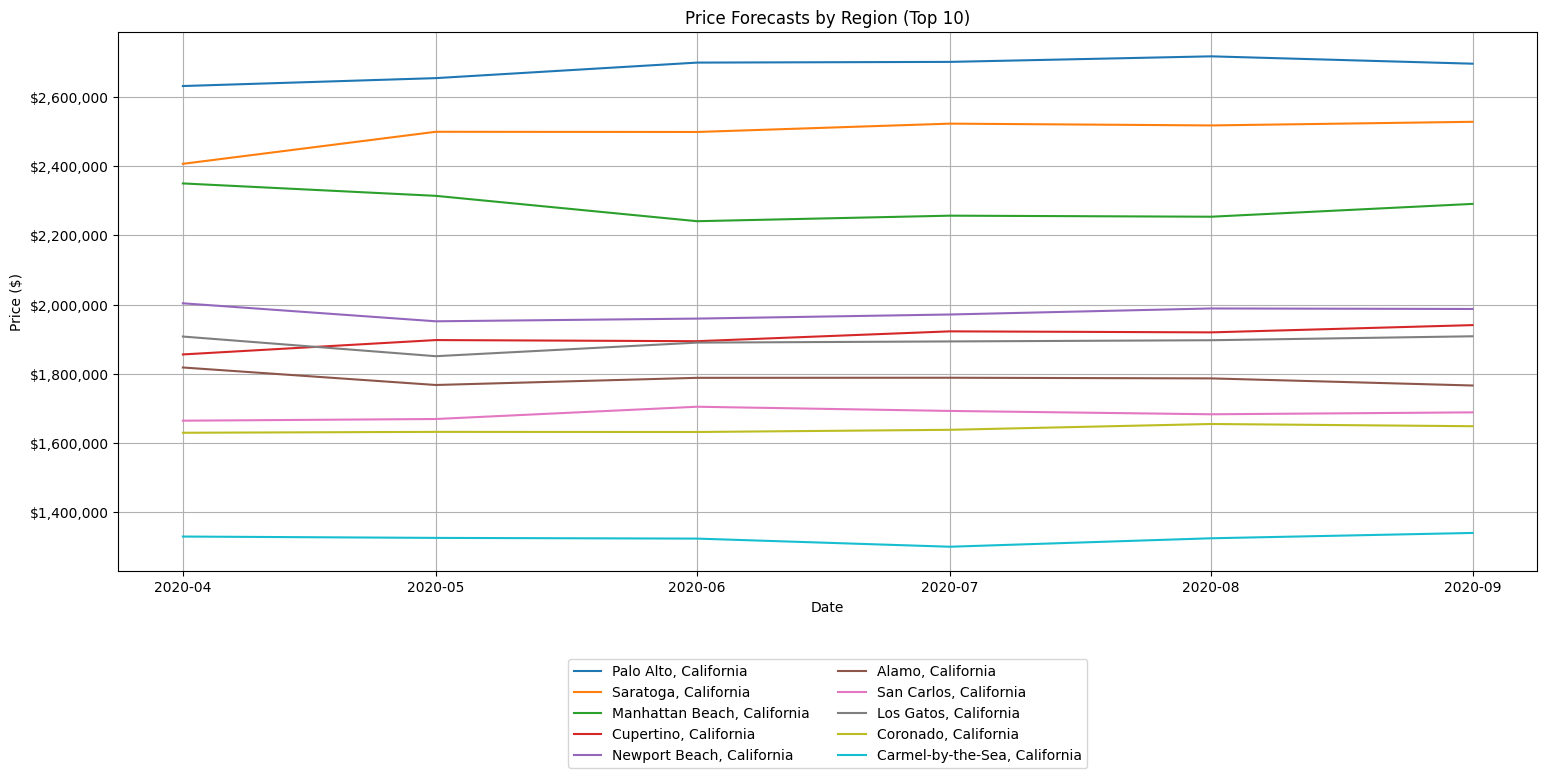

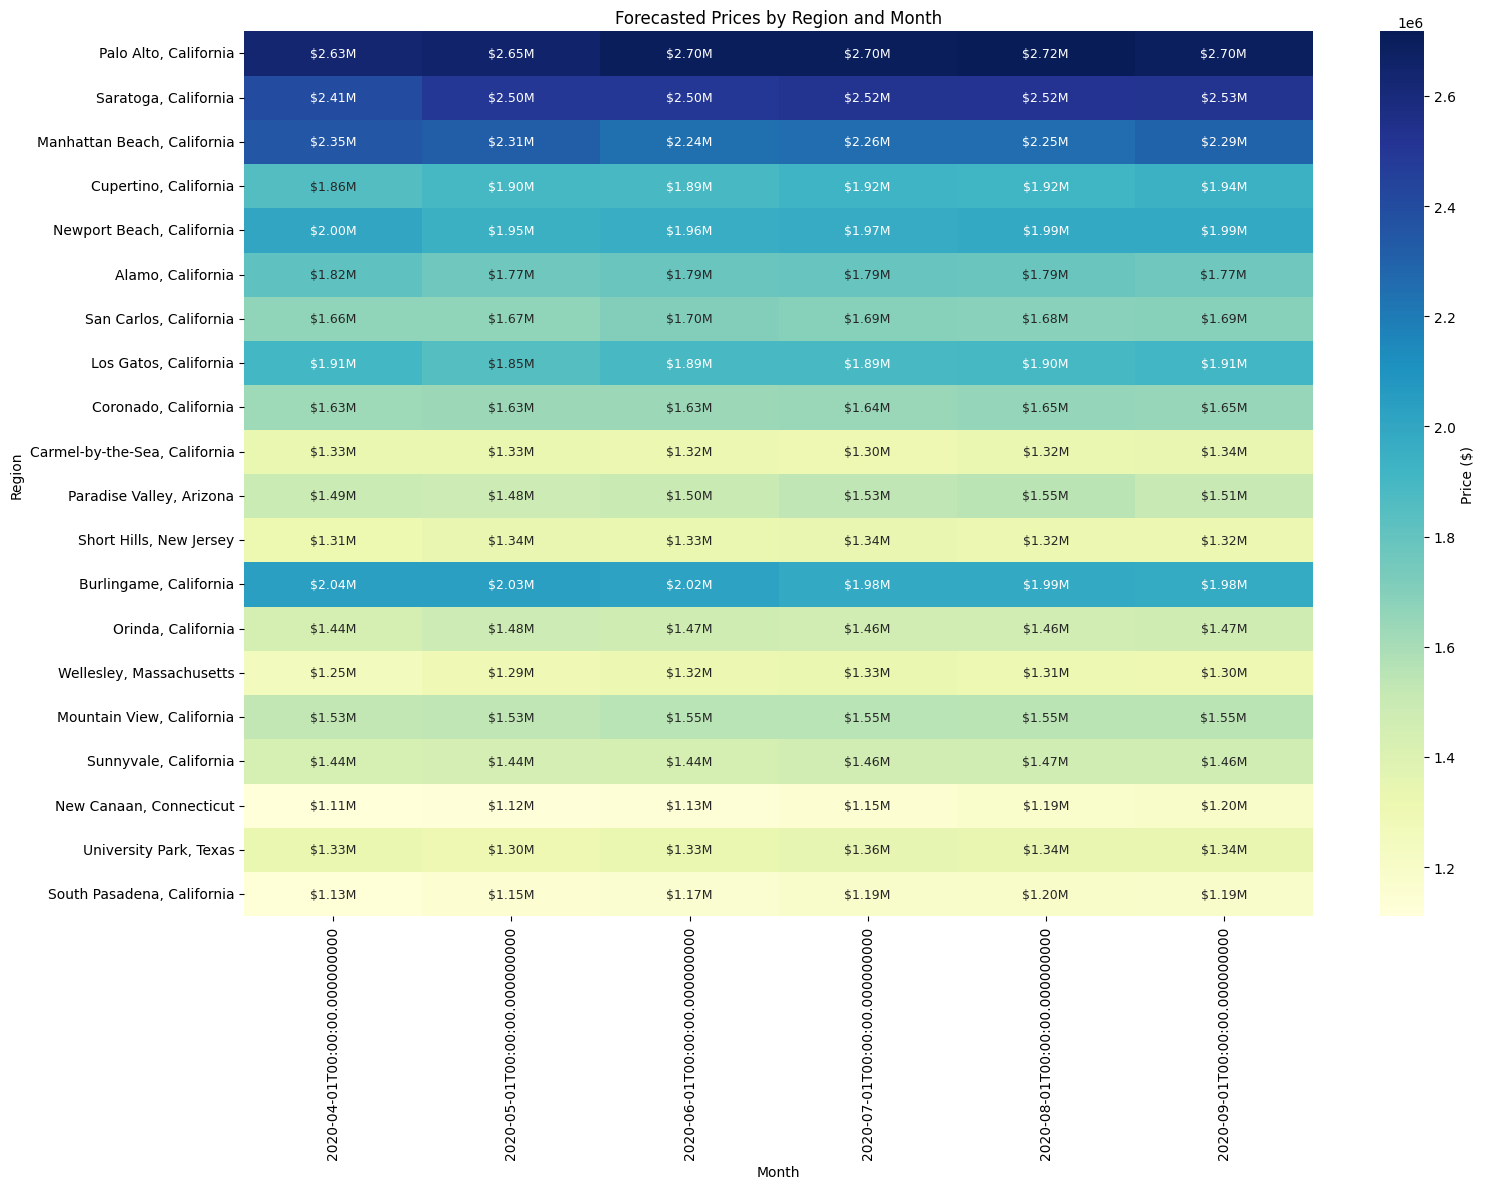


Projected Price Changes (First Month to Last Month):
                              First Month  Last Month    Change Pct Change
New Canaan, Connecticut        $1,110,703  $1,196,803   $86,100      7.75%
South Pasadena, California     $1,129,484  $1,190,257   $60,774      5.38%
Saratoga, California           $2,406,492  $2,527,924  $121,432      5.05%
Cupertino, California          $1,855,713  $1,940,439   $84,726      4.57%
Wellesley, Massachusetts       $1,254,415  $1,300,445   $46,030      3.67%
Palo Alto, California          $2,631,266  $2,695,811   $64,545      2.45%
Orinda, California             $1,441,587  $1,470,826   $29,239      2.03%
Sunnyvale, California          $1,436,640  $1,464,263   $27,623      1.92%
San Carlos, California         $1,664,281  $1,688,356   $24,075      1.45%
Paradise Valley, Arizona       $1,490,845  $1,508,271   $17,426      1.17%
Coronado, California           $1,629,403  $1,648,304   $18,901      1.16%
Mountain View, California      $1,530,328  $1,

In [10]:

# Combine all forecasts into a single DataFrame
if region_forecasts:
    all_forecasts = pd.DataFrame(region_forecasts)
    
    # Save to CSV (original numeric values)
    all_forecasts.to_csv('region_forecasts.csv')
    print("\nAll forecasts saved to 'region_forecasts.csv'")
    
    # Also save a formatted version with dollar signs
    formatted_forecasts_df = all_forecasts.applymap(lambda x: f"${x:,.2f}")
    formatted_forecasts_df.to_csv('region_forecasts_formatted.csv')
    print("Formatted forecasts saved to 'region_forecasts_formatted.csv'")
    
    # Plot forecasts for top regions
    plt.figure(figsize=(15, 8))
    
    # Select up to 10 regions for clearer visualization
    visible_regions = list(region_forecasts.keys())[:min(10, len(region_forecasts))]
    
    for region in visible_regions:
        plt.plot(region_forecasts[region], label=region)
        
    plt.title('Price Forecasts by Region (Top 10)')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.grid(True)
    plt.tight_layout()
    
    # Format y-axis with dollar signs and commas
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"${x:,.0f}"))
    
    plt.show()
    
    # Create a heatmap of forecasted prices
    plt.figure(figsize=(16, 12))
    
    # Format the numbers to be more readable
    # For heatmap annotation, use shorter dollar format (no cents)
    def format_price_for_heatmap(x):
        if x < 1000000:  # Less than a million
            return f"${x/1000:.0f}K"
        else:  # More than a million
            return f"${x/1000000:.2f}M"
    
    # Create heatmap with formatted values
    sns.heatmap(all_forecasts.T, cmap='YlGnBu', annot=True, 
               fmt="", annot_kws={"size": 9},
               cbar_kws={'label': 'Price ($)'})
    
    # Apply custom formatter to annotations
    for t in plt.gca().texts:
        try:
            # Convert text to float and format
            val = float(t.get_text())
            t.set_text(format_price_for_heatmap(val))
        except:
            pass
            
    plt.title('Forecasted Prices by Region and Month')
    plt.xlabel('Month')
    plt.ylabel('Region')
    plt.tight_layout()
    plt.show()
    
    # Calculate and display price changes
    print("\nProjected Price Changes (First Month to Last Month):")
    first_month = all_forecasts.iloc[0]
    last_month = all_forecasts.iloc[-1]
    pct_change = ((last_month - first_month) / first_month * 100).round(2)
    
    # Create a DataFrame with dollar-formatted values
    change_summary = pd.DataFrame({
        'First Month': first_month.apply(lambda x: f"${x:,.0f}"),
        'Last Month': last_month.apply(lambda x: f"${x:,.0f}"),
        'Change': (last_month - first_month).apply(lambda x: f"${x:,.0f}"),
        'Pct Change': pct_change.apply(lambda x: f"{x}%")
    })
    
    print(change_summary.sort_values('Pct Change', ascending=False))
else:
    print("No forecasts were generated for any region.")

### Part 3: Regional Forecasting and Analysis using Log transformation

 ```
Apply logarithm to stabilize variance (df['log'] = np.log(df['value']))
 ```

In [11]:
# Create a dictionary to store forecasts for each region
region_forecasts = {}

# Process forecasts for top regions
for region in top_regions:
    try:
        print(f"\nProcessing forecast for {region}...")
        
        # Filter data for this region
        region_data = df_melted[df_melted[city_column] == region]
        
        # Add state information if available
        region_label = region
        if state_column and len(region_data[state_column].unique()) == 1:
            state = region_data[state_column].iloc[0]
            if state != 'Unknown':
                region_label = f"{region}, {state}"
        
        # Handle missing values in Price
        region_data['Price'] = region_data['Price'].fillna(method='ffill')
        if region_data['Price'].isna().any():
            region_data['Price'] = region_data['Price'].fillna(method='bfill')
        if region_data['Price'].isna().any():
            region_data['Price'] = region_data['Price'].fillna(region_data['Price'].mean())
        
        # Group by month for this region
        region_monthly_avg = region_data.groupby('Month')['Price'].mean()
        
        # Skip regions with too little data
        if len(region_monthly_avg) < 4:
            print(f"  Skipping {region} - insufficient data ({len(region_monthly_avg)} months)")
            continue
        
        # Create a time series
        region_monthly_avg_with_freq = pd.Series(
            region_monthly_avg.values,
            index=pd.date_range(start=region_monthly_avg.index.min(), 
                                periods=len(region_monthly_avg), 
                                freq='MS')
        )
        
        # Apply log transformation to stabilize variance
        # Check for non-positive values first
        if (region_monthly_avg_with_freq <= 0).any():
            print(f"  Warning: Data for {region} contains zero or negative values. Adding offset before log transform.")
            # Add offset to make all values positive for log transform
            min_value = region_monthly_avg_with_freq.min()
            if min_value <= 0:
                offset = abs(min_value) + 1  # Add 1 to ensure all values are positive
                region_monthly_avg_log = np.log(region_monthly_avg_with_freq + offset)
                # Store offset for back-transformation later
                log_offset = offset
            else:
                region_monthly_avg_log = np.log(region_monthly_avg_with_freq)
                log_offset = 0
        else:
            region_monthly_avg_log = np.log(region_monthly_avg_with_freq)
            log_offset = 0
            
        print(f"  Applied log transformation to stabilize variance")
        
        # Use log-transformed data for decomposition
        use_decomposition = True
        try:
            period = min(12, len(region_monthly_avg_log)-1)
            if period < 2:
                use_decomposition = False
                raise ValueError("Period too small for decomposition")
                
            region_decomposition = seasonal_decompose(region_monthly_avg_log, model='additive', period=period)
            region_trend = region_decomposition.trend
            region_seasonal = region_decomposition.seasonal
            region_residual = region_decomposition.resid
        except Exception as e:
            print(f"  Decomposition error for {region}: {e}")
            print("  Using simpler forecasting method...")
            use_decomposition = False
        
        # Decide on forecasting method
        if use_decomposition:
            # Clean components for forecasting
            clean_residuals = region_residual.dropna()
            
            if len(clean_residuals) < 3:
                print(f"  Not enough clean data for ARIMA in {region}, using simpler method")
                use_decomposition = False
            else:
                #  ARIMA forecasting
                try:
                    model = ARIMA(clean_residuals, order=(1,1,1))
                    model_fit = model.fit()
                    
                    # Forecast next 6 periods
                    forecast_residuals = model_fit.forecast(steps=6)
                    
                    # Get the last valid trend value
                    last_valid_trend = region_trend.dropna().iloc[-1]
                    
                    # Get the seasonal pattern
                    seasonal_pattern = region_seasonal.dropna()
                    if len(seasonal_pattern) < 6:
                        # Reuse the available seasonal pattern
                        next_seasonal_values = np.tile(seasonal_pattern.values, 2)[:6]
                    else:
                        # Get the first 6 months of the seasonal pattern
                        next_seasonal_values = seasonal_pattern.iloc[:6].values
                        
                    # Rebuild the forecasted values by adding components (still in log space)
                    forecasted_log_values = forecast_residuals.values + last_valid_trend + next_seasonal_values
                    
                    # Create date range for forecast
                    last_date = region_monthly_avg_with_freq.index[-1]
                    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')
                    
                    # Transform back from log space to original scale
                    forecasted_values = np.exp(forecasted_log_values)
                    
                    # Remove offset if it was applied
                    if log_offset > 0:
                        forecasted_values = forecasted_values - log_offset
                    
                    # Create forecast Series with proper dates
                    region_forecasts[region_label] = pd.Series(forecasted_values, index=forecast_dates)
                    
                except Exception as e:
                    print(f"  ARIMA forecasting error for {region}: {e}")
                    print("  Using simpler forecasting method...")
                    use_decomposition = False
        
        # Simple forecast if decomposition/ARIMA failed
        if not use_decomposition:
            # Simple forecast using last value and average change
            # For this simpler method, we'll use the original (non-log) data
            if len(region_monthly_avg_with_freq) >= 2:
                avg_change = np.mean(region_monthly_avg_with_freq.diff().dropna())
                last_value = region_monthly_avg_with_freq.iloc[-1]
                forecast_values = [last_value + avg_change * (i+1) for i in range(6)]
                
                last_date = region_monthly_avg_with_freq.index[-1]
                forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')
                region_forecasts[region_label] = pd.Series(forecast_values, index=forecast_dates)
            else:
                print(f"  Not enough data points for {region} to create forecast")
            
    except Exception as e:
        print(f"Error processing {region}: {e}")

# Print forecasts for top regions with dollar formatting
print("\nForecasts for Top 20 Regions (next 6 months):")
for region, forecast in region_forecasts.items():
    print(f"\n{region} Forecast:")
    # Convert to dollar format with commas
    dollar_formatted = forecast.apply(lambda x: f"${x:,.2f}")
    print(dollar_formatted)


Processing forecast for Palo Alto...
  Applied log transformation to stabilize variance

Processing forecast for Saratoga...
  Applied log transformation to stabilize variance

Processing forecast for Manhattan Beach...
  Applied log transformation to stabilize variance

Processing forecast for Cupertino...
  Applied log transformation to stabilize variance

Processing forecast for Newport Beach...
  Applied log transformation to stabilize variance

Processing forecast for Alamo...
  Applied log transformation to stabilize variance

Processing forecast for San Carlos...
  Applied log transformation to stabilize variance

Processing forecast for Los Gatos...
  Applied log transformation to stabilize variance

Processing forecast for Coronado...
  Applied log transformation to stabilize variance

Processing forecast for Carmel-by-the-Sea...
  Applied log transformation to stabilize variance

Processing forecast for Paradise Valley...
  Applied log transformation to stabilize variance

P

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Processing forecast for Burlingame...
  Applied log transformation to stabilize variance

Processing forecast for Orinda...
  Applied log transformation to stabilize variance


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Processing forecast for Wellesley...
  Applied log transformation to stabilize variance

Processing forecast for Mountain View...
  Applied log transformation to stabilize variance

Processing forecast for Sunnyvale...
  Applied log transformation to stabilize variance

Processing forecast for New Canaan...
  Applied log transformation to stabilize variance

Processing forecast for University Park...
  Applied log transformation to stabilize variance

Processing forecast for South Pasadena...
  Applied log transformation to stabilize variance

Forecasts for Top 20 Regions (next 6 months):

Palo Alto, California Forecast:
2020-04-01    $2,578,996.21
2020-05-01    $2,605,490.45
2020-06-01    $2,668,829.90
2020-07-01    $2,684,124.79
2020-08-01    $2,720,873.59
2020-09-01    $2,695,027.46
Freq: MS, dtype: object

Saratoga, California Forecast:
2020-04-01    $2,339,647.33
2020-05-01    $2,411,152.68
2020-06-01    $2,387,341.42
2020-07-01    $2,411,308.15
2020-08-01    $2,410,929.17
2020-0


All forecasts saved to 'region_forecasts.csv'
Formatted forecasts saved to 'region_forecasts_formatted.csv'


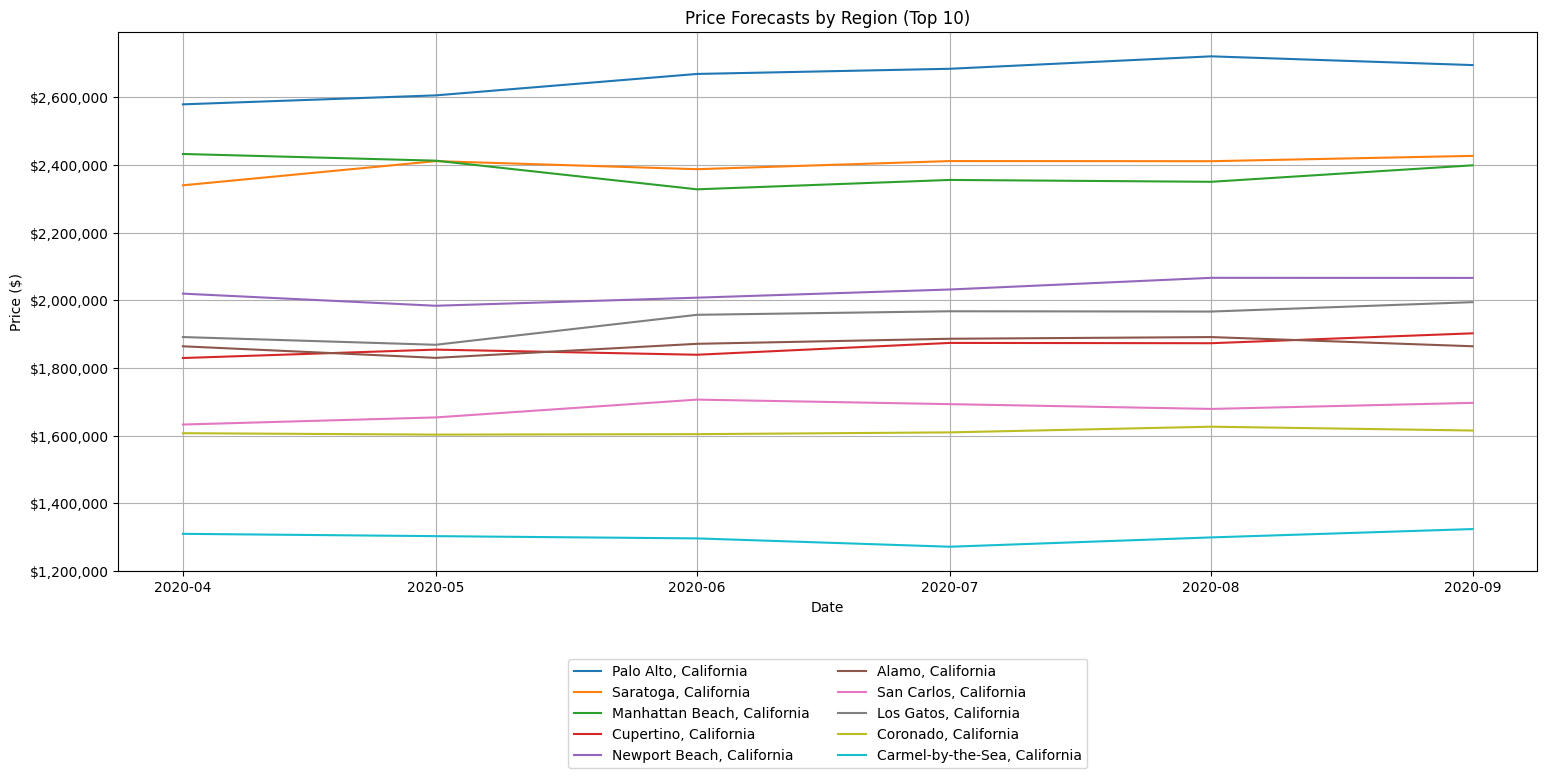

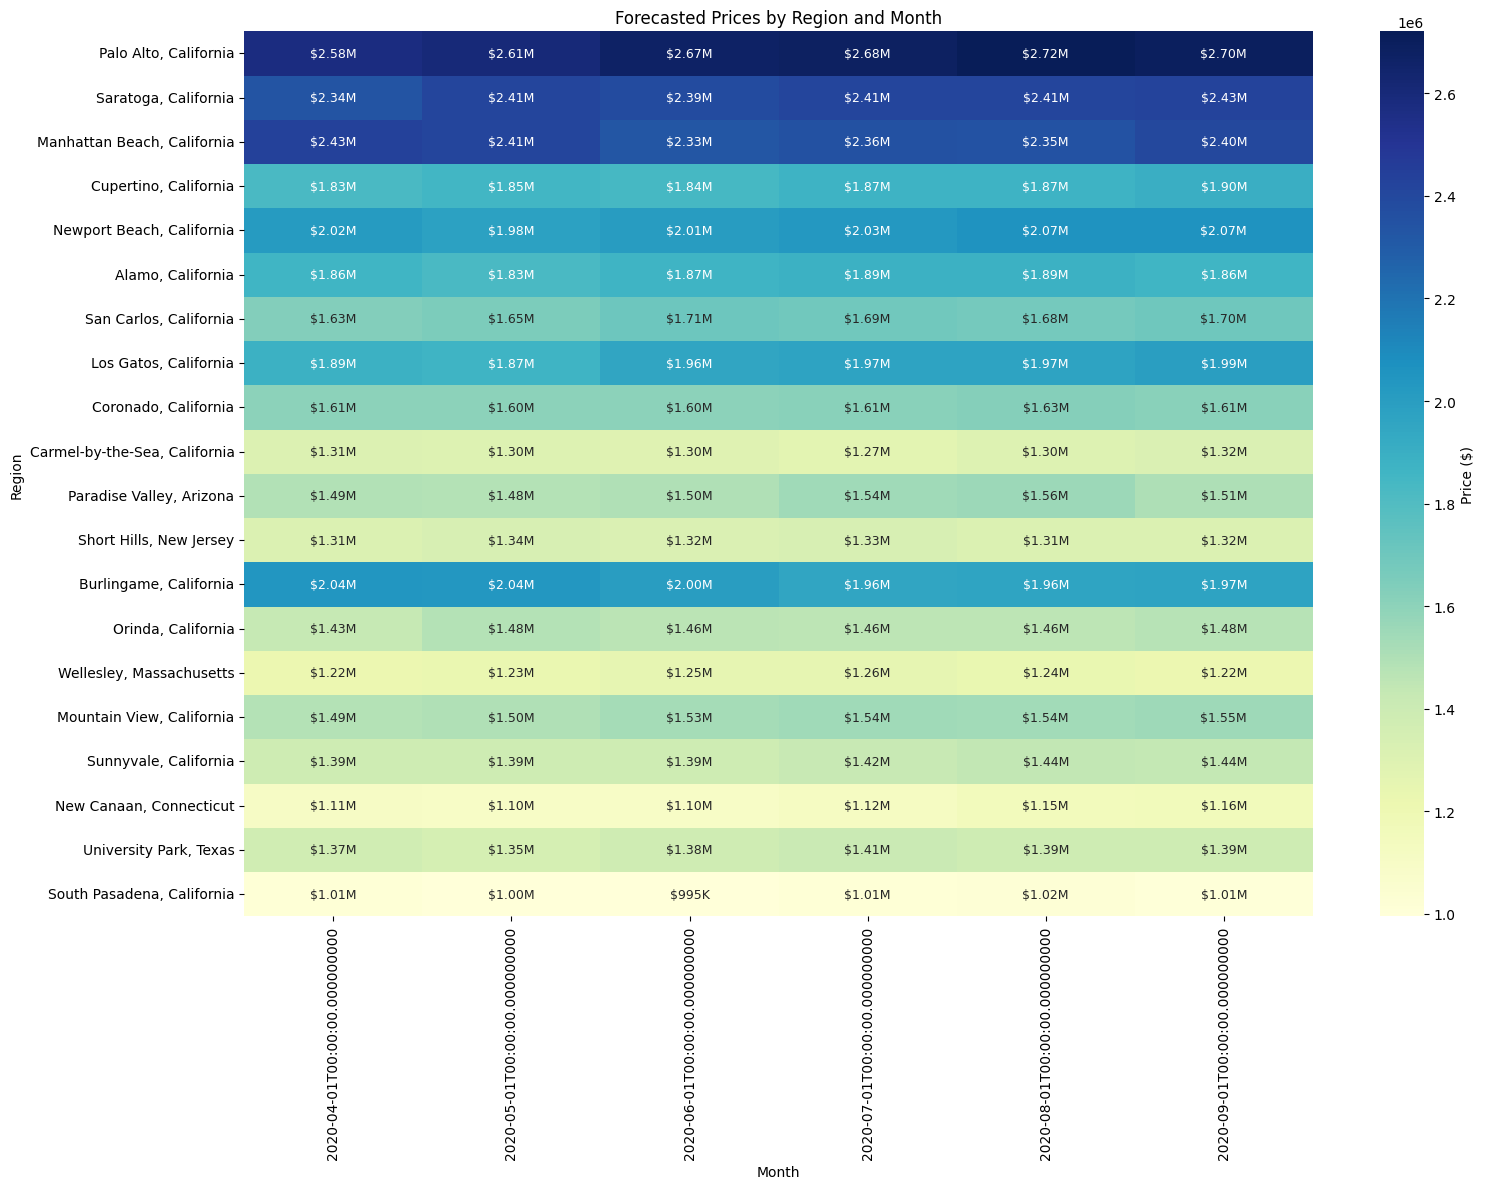


Projected Price Changes (First Month to Last Month):
                              First Month  Last Month    Change Pct Change
Los Gatos, California          $1,891,169  $1,994,321  $103,153      5.45%
New Canaan, Connecticut        $1,107,171  $1,162,981   $55,809      5.04%
Palo Alto, California          $2,578,996  $2,695,027  $116,031       4.5%
Mountain View, California      $1,485,611  $1,550,762   $65,150      4.39%
Cupertino, California          $1,829,155  $1,902,161   $73,006      3.99%
San Carlos, California         $1,632,582  $1,696,648   $64,066      3.92%
Saratoga, California           $2,339,647  $2,426,650   $87,002      3.72%
Sunnyvale, California          $1,390,674  $1,439,731   $49,056      3.53%
Orinda, California             $1,428,888  $1,478,300   $49,413      3.46%
Newport Beach, California      $2,019,485  $2,065,937   $46,452       2.3%
Paradise Valley, Arizona       $1,487,324  $1,505,137   $17,812       1.2%
Carmel-by-the-Sea, California  $1,309,519  $1,

In [12]:

# Combine all forecasts into a single DataFrame
if region_forecasts:
    all_forecasts = pd.DataFrame(region_forecasts)
    
    # Save to CSV (original numeric values)
    all_forecasts.to_csv('region_forecasts.csv')
    print("\nAll forecasts saved to 'region_forecasts.csv'")
    

    formatted_forecasts_df = all_forecasts.applymap(lambda x: f"${x:,.2f}")
    formatted_forecasts_df.to_csv('region_forecasts_formatted.csv')
    print("Formatted forecasts saved to 'region_forecasts_formatted.csv'")
    
    # Plot forecasts for top regions
    plt.figure(figsize=(15, 8))
    
    # Select up to 10 regions for clearer visualization
    visible_regions = list(region_forecasts.keys())[:min(10, len(region_forecasts))]
    
    for region in visible_regions:
        plt.plot(region_forecasts[region], label=region)
        
    plt.title('Price Forecasts by Region (Top 10)')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.grid(True)
    plt.tight_layout()
    
    # Format y-axis 
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"${x:,.0f}"))
    
    plt.show()
    
    # Create a heatmap of forecasted prices
    plt.figure(figsize=(16, 12))
    
    # Format the numbers to be more readable
    # For heatmap annotation
    def format_price_for_heatmap(x):
        if x < 1000000:  # Less than a million
            return f"${x/1000:.0f}K"
        else:  # More than a million
            return f"${x/1000000:.2f}M"
    
    # Create heatmap with formatted values
    sns.heatmap(all_forecasts.T, cmap='YlGnBu', annot=True, 
               fmt="", annot_kws={"size": 9},
               cbar_kws={'label': 'Price ($)'})
    
    # Apply custom formatter to annotations
    for t in plt.gca().texts:
        try:
            # Convert text to float and format
            val = float(t.get_text())
            t.set_text(format_price_for_heatmap(val))
        except:
            pass
            
    plt.title('Forecasted Prices by Region and Month')
    plt.xlabel('Month')
    plt.ylabel('Region')
    plt.tight_layout()
    plt.show()
    
    # Calculate and display price changes
    print("\nProjected Price Changes (First Month to Last Month):")
    first_month = all_forecasts.iloc[0]
    last_month = all_forecasts.iloc[-1]
    pct_change = ((last_month - first_month) / first_month * 100).round(2)
    
    # Create a DataFrame with dollar-formatted values
    change_summary = pd.DataFrame({
        'First Month': first_month.apply(lambda x: f"${x:,.0f}"),
        'Last Month': last_month.apply(lambda x: f"${x:,.0f}"),
        'Change': (last_month - first_month).apply(lambda x: f"${x:,.0f}"),
        'Pct Change': pct_change.apply(lambda x: f"{x}%")
    })
    
    print(change_summary.sort_values('Pct Change', ascending=False))
else:
    print("No forecasts were generated for any region.")

## Overall Analysis

Results of log transformation and seasonal decomposition:

### Growth Patterns

1. **Consistent Top Performers**: New Canaan (CT) and South Pasadena (CA) showed strong projected growth in both models, with New Canaan consistently leading at around 7.5-7.75% projected increase.

2. **Silicon Valley Dominance**: Cities in the San Francisco Bay Area (Saratoga, Cupertino, Palo Alto) show substantial growth in both analyses.

3. **Declining Markets**: Three markets consistently show projected price decreases across both methods:
   - Burlingame, CA: -4.08% (log) / -2.81% (seasonal)
   - Manhattan Beach, CA: -2.94% (log) / -2.52% (seasonal)
   - Alamo, CA: -2.85% (log) / -2.86% (seasonal)

### Method Comparison

1. **Estimation Differences**: The log transformation shows higher growth projections compared to seasonal decomposition.

2. **Significant Variations**:
   - Sunnyvale, CA: 5.28% growth (log) vs. only 1.92% (seasonal)
   - Mountain View, CA: 4.26% growth (log) vs. only 1.13% (seasonal)
   - Los Gatos, CA: 3.14% growth (log) vs. nearly flat 0.04% (seasonal)

3. **Newport Beach Anomaly**: Shows minimal growth (0.07%) in log transformation but a decline (-0.82%) in seasonal decomposition.

### Geographic Insights

1. **California Mixed Performance**: California markets show both the highest growth projections (Saratoga, Cupertino) and the steepest declines (Burlingame, Manhattan Beach).

2. **East Coast Stability**: New Canaan (CT), Wellesley (MA), and Short Hills (NJ) all show consistent positive growth across both methods.

3. **Texas and Arizona Stability**: University Park (TX) and Paradise Valley (AZ) show modest but consistent growth projections.